In [1]:
import os
os.environ["WANDB_START_METHOD"] = "thread"

import sys
sys.path.append('/SeqPred')

from argparse import ArgumentParser
import torch
import pandas as pd
import tutils
import wandb
from datetime import datetime
import copy
from data.spetDataset import SpetDataset
from torch.utils.data import DataLoader
import pandas as pd
import torch
from model.configuration_csept import CseptConfig
from model.modeling_csept import CspetForSequencePrediction
from typing import Any
import numpy as np




# main
parser = ArgumentParser()
parser.add_argument('--project_name', type=str, default="csept")
parser.add_argument('--hidden_size', type=int, default=16)
parser.add_argument('--num_hidden_layers', type=int, default=8)
parser.add_argument('--num_attention_heads', type=int, default=4)  # query heads, also attention heads
parser.add_argument('--num_key_value_heads', type=int, default=4)  # key and value heads
parser.add_argument('--intermediate_size', type=int, default=32)
parser.add_argument('--train_noise_level', type=float, default=0.001)
parser.add_argument('--pred_length', type=int, default=512)
parser.add_argument('--learning_rate', type=float, default=1e-4)
parser.add_argument('--epochs', type=int, default=500)
parser.add_argument('--early_stopping_patience', type=int, default=100)
parser.add_argument('--batch_size', type=int, default=256)
parser.add_argument('--optimizer', type=str, default="adam")
parser.add_argument('--hidden_act', type=str, default="silu", choices=["gelu", "relu", "silu", "tanh", 'sigmoid', 'mish'])
parser.add_argument('--loss_type', type=str, default="mse", choices=["mse", "mae", "smooth_l1", "log_cosh", "huber"])
parser.add_argument('--window_size', type=int, default=2)
args = parser.parse_args([])
DEVICE = 'cuda'


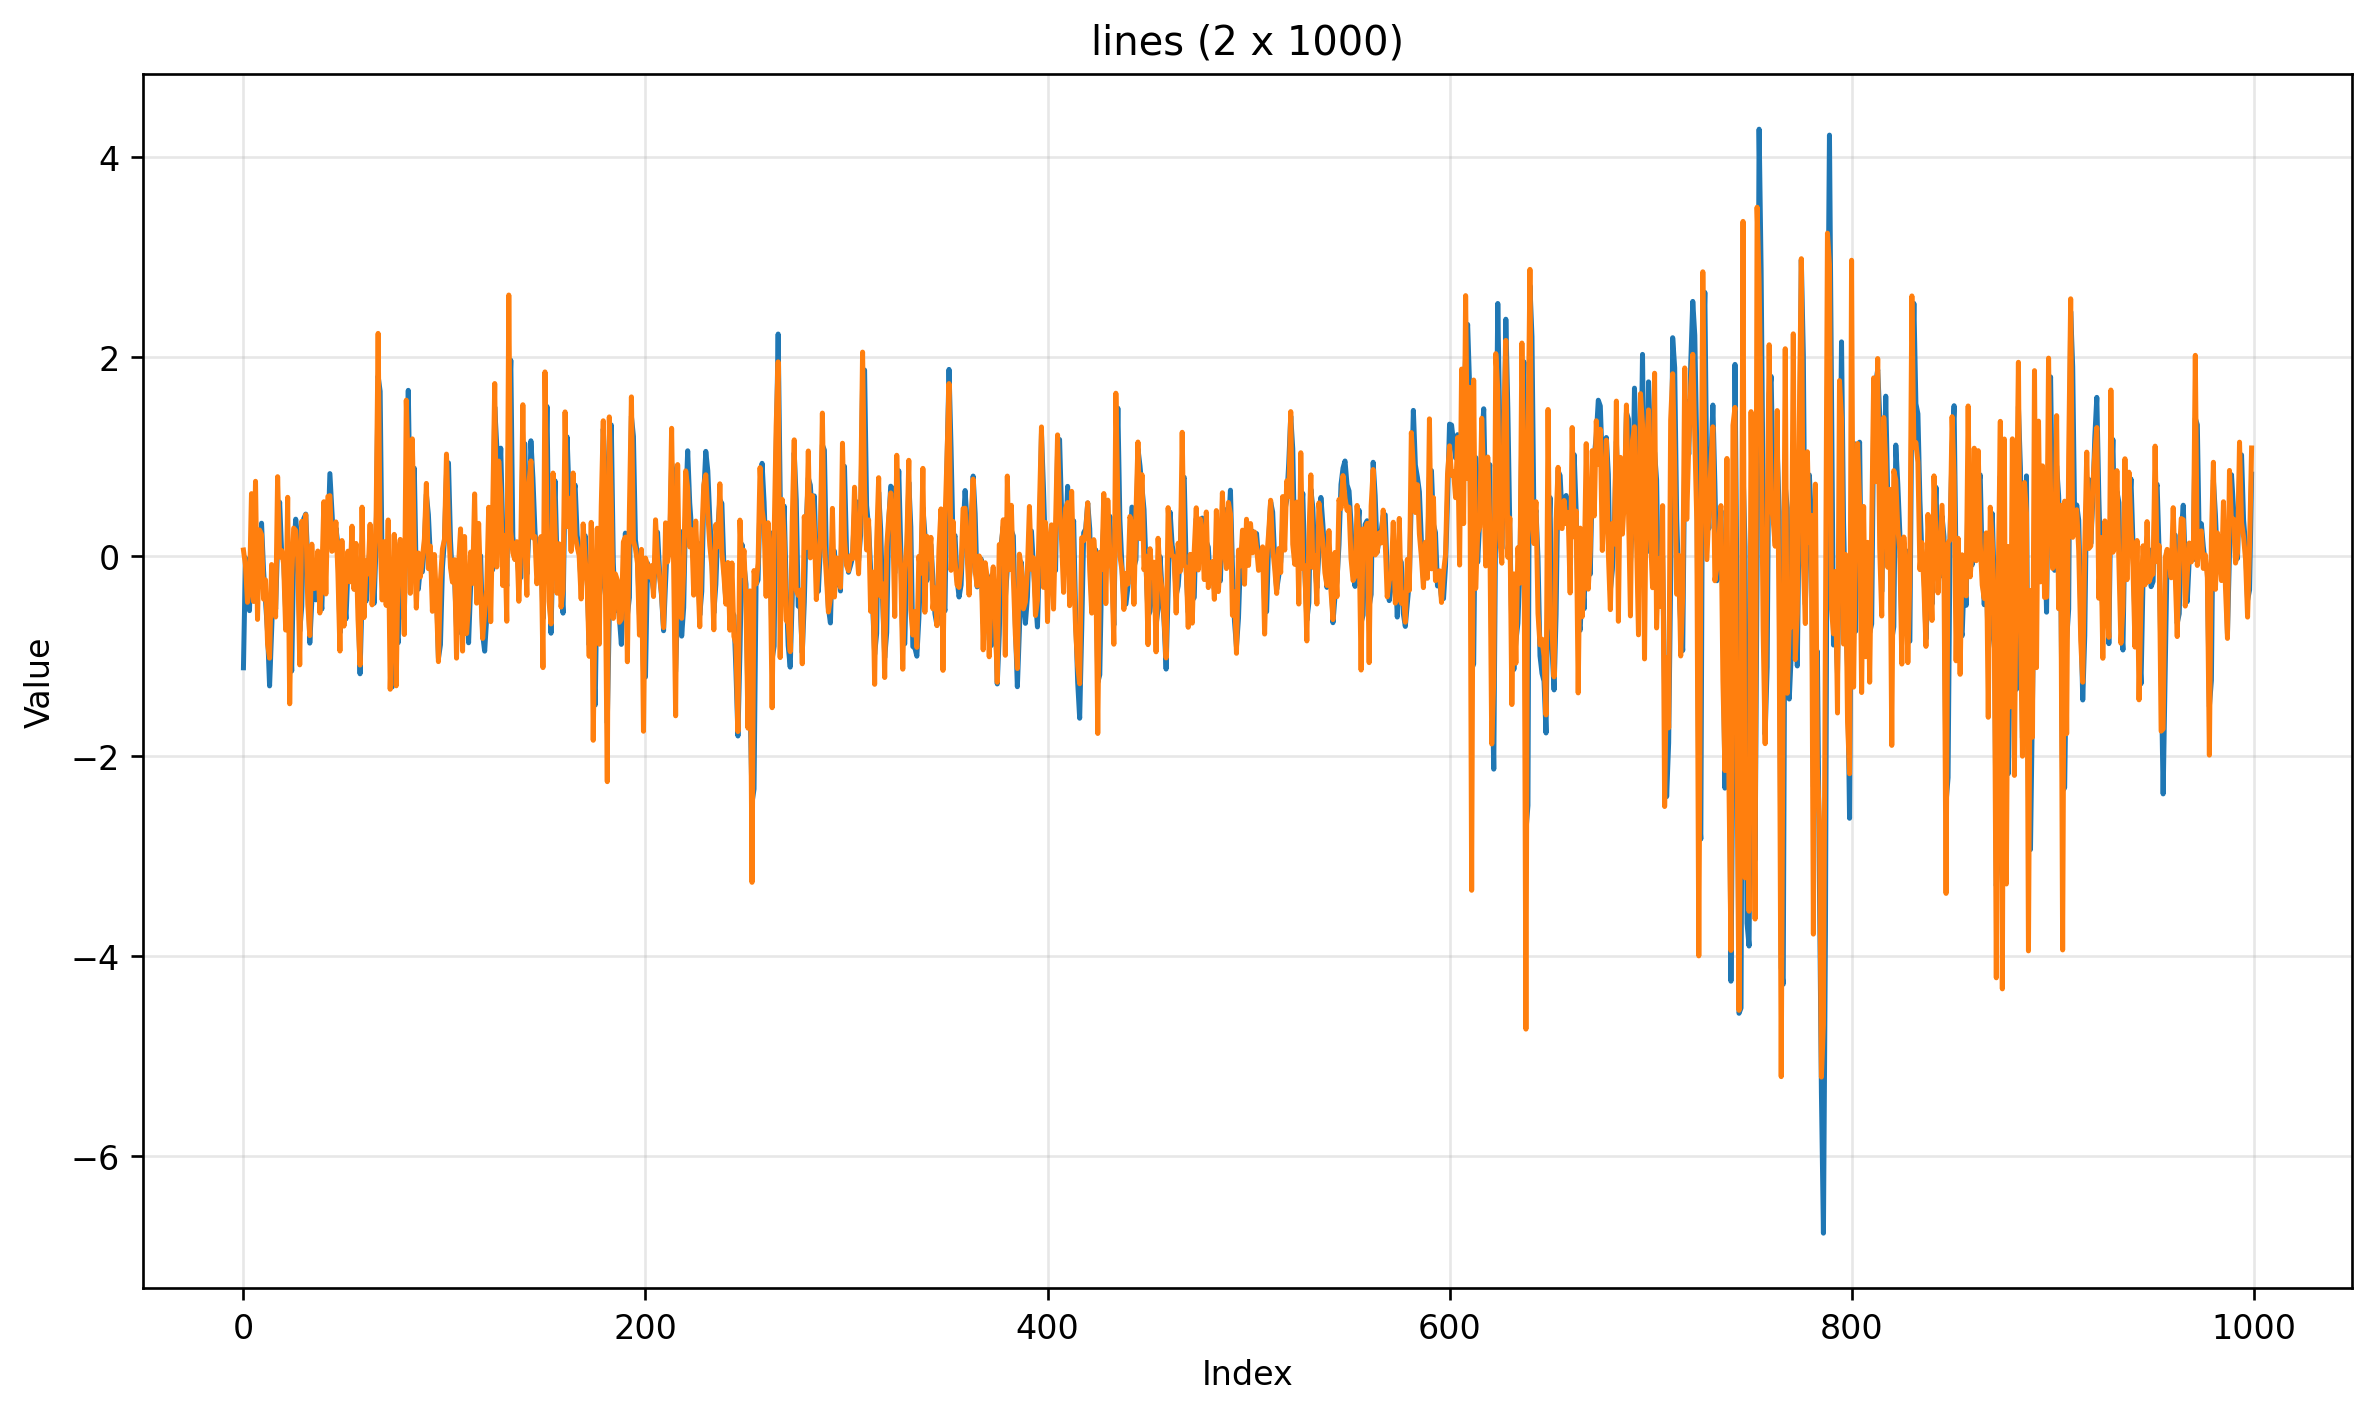

In [2]:
data = pd.read_csv('/SeqPred/data/data.csv')
close = data['Close'].pct_change().tolist()[1:]

raw_train_data = SpetDataset(csv_file='/SeqPred/data/data.csv', pred_length=args.pred_length, is_train=True, noise_level=args.train_noise_level, window_size=1)
train_dataset = SpetDataset(csv_file='/SeqPred/data/data.csv', pred_length=args.pred_length, is_train=True, noise_level=args.train_noise_level, window_size=args.window_size)
test_dataset = SpetDataset(csv_file='/SeqPred/data/data.csv', pred_length=args.pred_length, is_train=False, window_size=args.window_size)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True)


tutils.plot.plot_lines([train_dataset.data[:, 0], raw_train_data.data[:, 0]])


In [3]:
def init_wandb(args):
    wandb_run = wandb.init(
        entity='terrencechen',
        project=args.project_name,
        name=datetime.now().strftime("%Y%m%d_%H%M%S"),
        config=args
    )
    return wandb_run

class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.best_model = None

    def _is_improved(self, loss, best_loss):
        return loss < best_loss - self.min_delta

    def __call__(self, loss, model):
        if self._is_improved(loss, self.best_loss):
            self.best_loss = loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
        if self.counter >= self.patience:
            return True
        return False

    def load_best_model(self, model):
        if self.best_model is not None:
            model.load_state_dict(self.best_model)
        else:
            raise ValueError("No best model found")

class Trainer:
    def __init__(self, model, train_loader, test_loader, optimizer):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.device = model.device
        print(f"Using device: {self.device}")
    
    def train_epoch(self, epoch):
        self.model.train()
        train_loss = 0

        for input_values, labels in self.train_loader:
            input_values, labels = input_values.to(self.device), labels.to(self.device)
            
            output = self.model(input_values=input_values, labels=labels)
            
            loss = output.loss
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            train_loss += loss.item()

        return train_loss / len(self.train_loader)

    @torch.no_grad()
    def evaluate(self, data_loader=None):

        if data_loader is None:
            data_loader = self.test_loader

        self.model.eval()
        test_loss = 0
        for input_values, labels in data_loader:
            input_values, labels = input_values.to(self.device), labels.to(self.device)
            # print(input_values.dtype, labels.dtype)

            output = self.model(input_values=input_values, labels=labels)
            loss = output.loss
            test_loss += loss.item()

        return test_loss / len(self.test_loader)

wandb_run = init_wandb(args)


wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
wandb: Currently logged in as: terrencecchen (terrencechen) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
config = CseptConfig(
    input_size=5,  # Close, Open, High, Low, Volume
    hidden_size=args.hidden_size,
    num_hidden_layers=args.num_hidden_layers,
    num_attention_heads=args.num_attention_heads,
    num_key_value_heads=args.num_key_value_heads,
    intermediate_size=args.intermediate_size,
    max_position_embeddings=args.pred_length,
    hidden_act=args.hidden_act,
    loss_type=args.loss_type,
)
print(config)
model = CspetForSequencePrediction(config).to(DEVICE)
model


CseptConfig {
  "attention_dropout": 0.0,
  "hidden_act": "silu",
  "hidden_size": 16,
  "initializer_range": 0.02,
  "input_size": 5,
  "intermediate_size": 32,
  "loss_type": "mse",
  "max_position_embeddings": 512,
  "max_window_layers": 28,
  "model_type": "csept",
  "num_attention_heads": 4,
  "num_hidden_layers": 8,
  "num_key_value_heads": 4,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "sliding_window": 4096,
  "tie_word_embeddings": false,
  "transformers_version": "4.52.3",
  "use_cache": true,
  "use_sliding_window": false
}



CspetForSequencePrediction(
  (model): CseptModel(
    (embed_proj): Linear(in_features=5, out_features=16, bias=True)
    (layers): ModuleList(
      (0-7): 8 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=16, out_features=16, bias=True)
          (k_proj): Linear(in_features=16, out_features=16, bias=True)
          (v_proj): Linear(in_features=16, out_features=16, bias=True)
          (o_proj): Linear(in_features=16, out_features=16, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=16, out_features=32, bias=False)
          (up_proj): Linear(in_features=16, out_features=32, bias=False)
          (down_proj): Linear(in_features=32, out_features=16, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((16,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((16,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((16,), eps=1e-06)
    (rotary_emb): Qw

In [5]:

optimizer = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD,
    'adagrad': torch.optim.Adagrad,
}[args.optimizer](model.parameters(), lr=args.learning_rate)


stopper = EarlyStopper(patience=args.early_stopping_patience)
trainer = Trainer(model, train_loader, test_loader, optimizer)

# For prediction in training process
train_input_values, train_labels = next(iter(train_loader))
eval_input_values, eval_labels = next(iter(test_loader))

# Forward prediction
def forward_pred(input_values, labels, title, step):
    input_values, labels = input_values.to(DEVICE), labels.to(DEVICE)
    output = model(input_values=input_values, labels=labels)
    pred = output.preds
    ture = labels[:, : ,0:1]
    true = ture[0].detach().cpu().squeeze(-1).numpy()
    pred = pred[0].detach().cpu().squeeze(-1).numpy()
    fig = tutils.plot.plot_lines([true, pred], title=title)
    return fig


# Generate prediction
@torch.no_grad()
def generate_pred(input_values, labels, title, step):
    
    input_values = input_values.to(DEVICE)  
    max_length=100
    generated_values = [input_values[:, :args.pred_length-max_length, 0:1].clone()]
    model.eval()

    for i in range(max_length):
        
        output = model.forward(input_values=input_values)

        preds = output.preds[:, -1:, :]
        batch_size = preds.shape[0]
        next_token = train_dataset.mean.clone().to(DEVICE).unsqueeze(0).expand(batch_size, -1).unsqueeze(1)  # (batch_size, 1, feature_dim)
        next_token = next_token.clone()
        next_token = torch.randn_like(next_token)
        next_token[:, :, 0:1] = preds

        input_values = torch.cat([input_values, next_token], dim=-2)

        generated_values.append(preds)

    pred =torch.cat(generated_values, dim=-2).squeeze(-1).detach().cpu().numpy()
    ture = labels[:, :, 0:1].squeeze(-1).detach().cpu().numpy()
    change_fig = tutils.plot.plot_lines([ture[0], pred[0]], title=f'{title}_change')

    def transfer_change_rate_to_price(change_rate, init_values=1):
        price = np.zeros_like(change_rate)
        price[0] = init_values
        for i in range(1, price.shape[0]):
            price[i] = price[i-1] * (1 + change_rate[i])
        return price

    true_price = transfer_change_rate_to_price(ture[0] * train_dataset.std[0].item() + train_dataset.mean[0].item())
    pred_price = transfer_change_rate_to_price(pred[0] * train_dataset.std[0].item() + train_dataset.mean[0].item())

    price_fig = tutils.plot.plot_lines([true_price, pred_price], title=f'{title}_price')
    return change_fig,  price_fig


# Evaluate before training
log_dict = {
    "train_loss": trainer.evaluate(train_loader),
    "test_loss": trainer.evaluate(test_loader),
}
wandb_run.log(log_dict, step=0)
print(f"[Initial] Train loss: {log_dict['train_loss']}, Test loss: {log_dict['test_loss']}")


# Training process
for epoch in range(args.epochs):
    train_loss = trainer.train_epoch(epoch)
    train_loss = trainer.evaluate(train_loader)
    test_loss = trainer.evaluate(test_loader)

    print(f"Epoch {epoch+1} train loss: {train_loss}, test loss: {test_loss}")

    forward_pred_train = forward_pred(train_input_values, train_labels, "forward_pred_train", epoch)
    forward_pred_test = forward_pred(eval_input_values, eval_labels, "forward_pred_test", epoch)
    # generate_pred_change_train, generate_pred_price_train = generate_pred(train_input_values, train_labels, "generate_pred_train", epoch)
    # generate_pred_change_test, generate_pred_price_test = generate_pred(eval_input_values, eval_labels, "generate_pred_test", epoch)

    log_dict = {
        "train_loss": train_loss,
        "test_loss": test_loss,
        "forward_pred_train": wandb.Image(forward_pred_train),
        "forward_pred_test": wandb.Image(forward_pred_test),
        # "generate_pred_change_train": wandb.Image(generate_pred_change_train),
        # "generate_pred_price_train": wandb.Image(generate_pred_price_train),
        # "generate_pred_change_test": wandb.Image(generate_pred_change_test),
        # "generate_pred_price_test": wandb.Image(generate_pred_price_test),
    }
    wandb_run.log(log_dict, step=epoch)

    if stopper(test_loss, model):
        print(f"Early stopping at epoch {epoch+1}")
        break


Using device: cuda:0
[Initial] Train loss: 0.8728371262550354, Test loss: 0.2736399173736572
Epoch 1 train loss: 0.8688995540142059, test loss: 0.27167902886867523
Epoch 2 train loss: 0.8663742244243622, test loss: 0.2700003534555435
Epoch 3 train loss: 0.8640109300613403, test loss: 0.26845668256282806
Epoch 4 train loss: 0.8577720522880554, test loss: 0.26710207760334015
Epoch 5 train loss: 0.8548860251903534, test loss: 0.2658618539571762
Epoch 6 train loss: 0.8513019680976868, test loss: 0.2646677494049072
Epoch 7 train loss: 0.846686452627182, test loss: 0.26362261176109314
Epoch 8 train loss: 0.8436749279499054, test loss: 0.2624128609895706
Epoch 9 train loss: 0.8420603275299072, test loss: 0.2609350234270096
Epoch 10 train loss: 0.8389150202274323, test loss: 0.2592307776212692
Epoch 11 train loss: 0.8374398648738861, test loss: 0.25750574469566345
Epoch 12 train loss: 0.8334364295005798, test loss: 0.2557767629623413
Epoch 13 train loss: 0.828158974647522, test loss: 0.2540465

In [7]:
train_dataset.data.shape


torch.Size([1000, 5])

In [ ]:
start_idx = 4000
end_idx = 4200
pred_length = 100

raw_train_data = data['Close'].pct_change().tolist()[1:]
rolling_mean_train = pd.Series(raw_train_data).rolling(window=args.window_size).mean().tolist()

sample_data = torch.tensor(rolling_mean_train[start_idx:end_idx]).unsqueeze(0).unsqueeze(-1)
sample_data = (sample_data - train_dataset.mean[0].item()) / train_dataset.std[0].item()
sample_data.shape



with torch.no_grad():
    for i in range(pred_length):
        sample_data = sample_data.to(DEVICE)
        output = model(sample_data)
        pred = output.preds[:, -1:, :]
        sample_data = torch.cat([sample_data, pred], dim=-2)

sample_data = sample_data.cpu() * train_dataset.std[0].item() + train_dataset.mean[0].item()
pred = sample_data.squeeze(-1).squeeze(0).detach().cpu().numpy()
# for i in range(window_size):
#     pred[i] = raw_train_data[start_idx+i]

# for i in range(window_size, pred.shape[0]):
#     pred[i] = pred[i] * window_size - sum(pred[i-window_size+1:i])

tutils.plot.plot_lines([rolling_mean_train[start_idx:end_idx+pred_length], pred.tolist()])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (200x1 and 5x16)